In [93]:
## IMPORT: ------------------------------------
import scipy.stats as stats #It has all the probability distributions available along with many statistical functions.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') # To supress warnings
sns.set(style="darkgrid") # set the background for the graphs
from scipy.stats import skew
from statsmodels.stats.proportion import proportions_ztest # For proportion Z-test
from statsmodels.formula.api import ols      # For n-way ANOVA
from statsmodels.stats.anova import anova_lm # For n-way ANOVA
from scipy.stats import chi2_contingency   # For Chi-Sq 


In [94]:
#Reading the csv file AxisInsurance.csv 
data_path='../Data/insurance.csv'
df=pd.read_csv(data_path)
insured=df.copy()   # .copy() : 깊은 복사. 원본 데이터를 보존하기 위해 사용

In [95]:
insured.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [96]:
insured.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


결측데이터 없음   


In [97]:
objectList = ['sex', 'smoker', 'region']
for x in objectList:
    print(x, insured[x].unique())

sex ['female' 'male']
smoker ['yes' 'no']
region ['southwest' 'southeast' 'northwest' 'northeast']


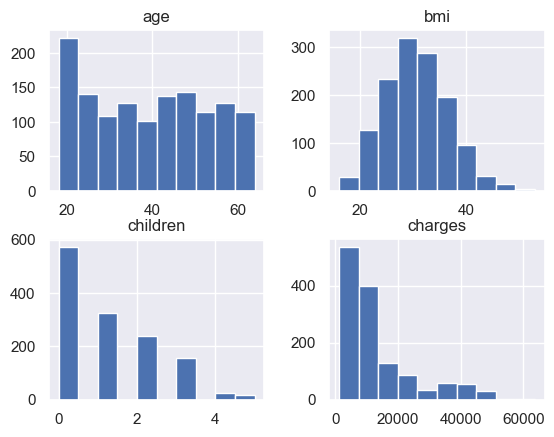

               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010 

age 0.055610083072599126 1.7550793195415773
bmi 0.28372857291709386 2.9449768941629997
children 0.9373281163874423 3.197217426862373
charges 1.5141797118745743 4.595821363956751


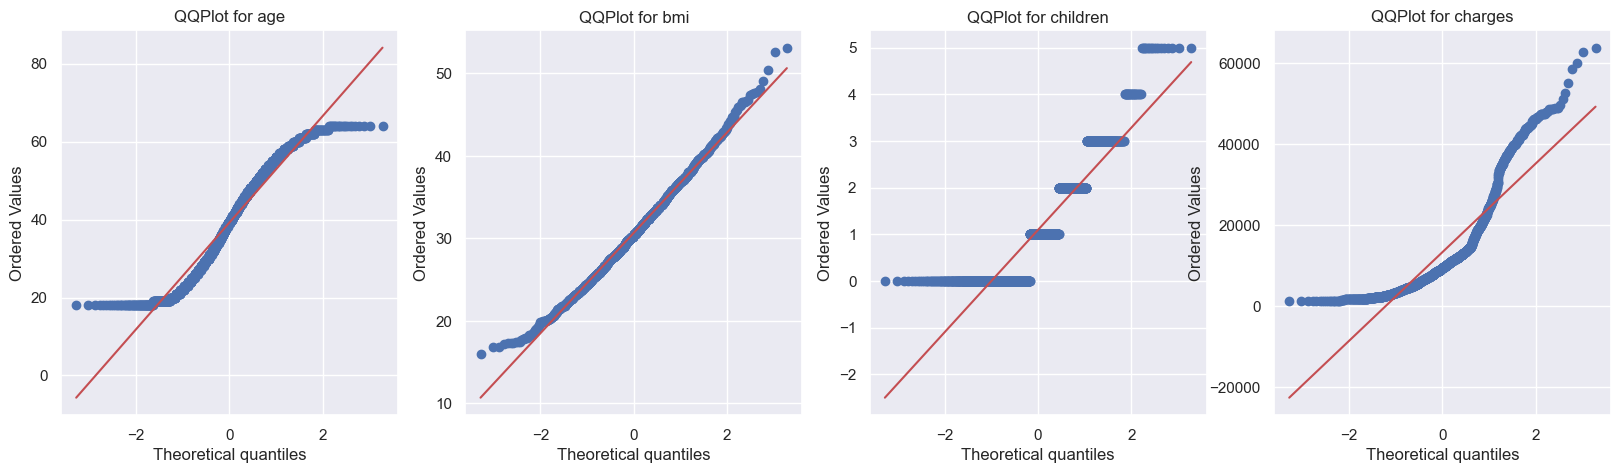

In [98]:
# 숫자형 데이터들의 정규성 여부를 판별해 보자!
from scipy.stats import kurtosis

numbericList=['age','bmi','children','charges']     # charges -> y로 사용

# 방법 1) 히스토그램
insured.hist()      # 수치형 데이터로만 히스토그램 나옴 - 정규성 여부 판단 위함.
plt.show()

# 방법 2) describe()으로 기술통계 보며 데이터분포 확인
print(insured.describe(), "\n")

# 방법 3) 왜도와 첨도로 데이터의 비대칭도 확인
for x in numbericList:
    print(x, skew(insured[x]), kurtosis(insured[x], fisher=False))

# 방법 4) Q-Q plot로 정규성 확인
import statsmodels.api as sm

plt.figure(figsize=(20,5))

# plt.subplot(1,4,1)
# col='age'
# stats.probplot(insured[col], dist="norm", plot=plt)
# plt.title(f"QQPlot for {col}")

# plt.subplot(1,4,2)
# col='bmi'
# stats.probplot(insured[col], dist="norm", plot=plt)
# plt.title(f"QQPlot for {col}")

# plt.subplot(1,4,3)
# col='children'
# stats.probplot(insured[col], dist="norm", plot=plt)
# plt.title(f"QQPlot for {col}")

# plt.subplot(1,4,4)
# col='charges'
# stats.probplot(insured[col], dist="norm", plot=plt)
# plt.title(f"QQPlot for {col}")

for i in range(len(numbericList)):
    plt.subplot(1,4,i+1)
    col=numbericList[i]
    stats.probplot(insured[col], dist="norm", plot=plt)
    plt.title(f"QQPlot for {col}")


charges, children는 정규성을 띄지 않는 것으로 보이고, age, bmi는 정규성을 따르는 것으로 보인다   
         
But, children은 숫자가 아닌, categorical data로 봐야하기 때문에, 데이터타입을 바꿔줘야 하며,   
    애초에 charges는 y값인데, y값은 정규성을 따지지 않는다. 

              age       bmi   charges
age      1.000000  0.109272  0.299008
bmi      0.109272  1.000000  0.198341
charges  0.299008  0.198341  1.000000


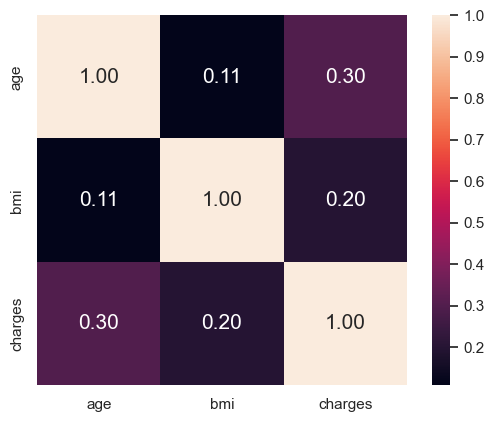

In [99]:
# charges와 다른 변수들이 얼마나 상관관계 있는지 확인 -> 어떤 변수를 이용해서 가설설정/검증 할건지
# 명목형은 상관관계 힘드니까 수치형 변수만 이걸로 확인

numbericList = ['age','bmi','charges']                  # children은 categorical이라 제외
corr = insured[numbericList].corr(method='pearson')
print(corr)

hm = sns.heatmap(corr.values, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, yticklabels=numbericList, xticklabels=numbericList)
plt.show()

음.. 수치형 변수들은 charges와 정말 상관관계가 없었다...

이번에는 명목형 변수 인코딩해서 해보자.   
    
- sex : 0(female), 1(male)   
- smoker : 0(no), 1(yes)   
- region : 0(northeast), 1(northwest), 2(southeast), 3(southwest)

### 명목형 변수의 정규성 검정 방법
: 다양성 지수, 빈도 분석, 카이제곱검정

In [100]:
insured.sex = insured['sex'].astype('category')
insured.smoker = insured['smoker'].astype('category')
insured.region = insured['region'].astype('category')

#### 명목형 변수의 다양성 지수 확인 - 편중된 데이터가 있는지 확인
col='smoker'
value_counts = insured[col].value_counts()
p =  value_counts/len(insured)

# 샤넌 엔트로피 계산 : 값이 클수록 데이터가 고르게 분포
shannon_entropy = -np.sum(p*np.log2(p))
print(f"Shannon Entropy of {col} is {shannon_entropy}")

# 지니계수 계산 : 0에 가까울수록 데이터가 고르게 분포
gini_index = 1-np.sum(p**2)
print(f"Gini Index of {col} is {gini_index}")

Shannon Entropy of smoker is 0.7313920702196
Gini Index of smoker is 0.32569415118832956


In [101]:
# 명목형 변수 인코딩
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
insured['sex'] = le.fit_transform(insured['sex'])
insured['smoker'] = le.fit_transform(insured['smoker'])
insured['region'] = le.fit_transform(insured['region'])

insured.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520
5,31,0,25.740,0,0,2,3756.62160
6,46,0,33.440,1,0,2,8240.58960
7,37,0,27.740,3,0,1,7281.50560
8,37,1,29.830,2,0,0,6406.41070
9,60,0,25.840,0,0,1,28923.13692


count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64


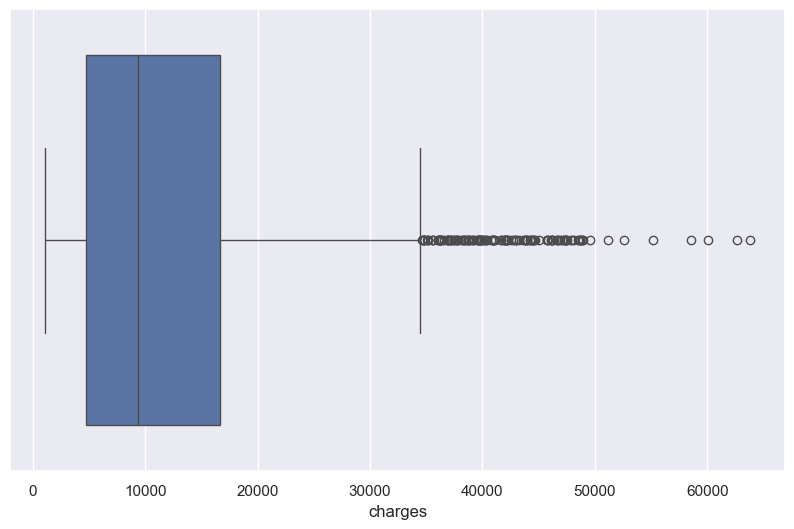

In [102]:
# 카이제곱하기 위해 데이터 분포 알아보기

print(insured['charges'].describe())

plt.figure(figsize=(10, 6))
sns.boxplot(data=insured['charges'], orient='h')
plt.show()

In [103]:
insured['charges'] = np.log(insured['charges'])
insured['charges'].describe()

count    1338.000000
mean        9.098659
std         0.919527
min         7.022756
25%         8.463853
50%         9.146552
75%         9.719558
max        11.063045
Name: charges, dtype: float64

꼬리가 기니까 로그변환을 한 후에 사분위로 나눴어야 했나..?

In [104]:
import scipy.stats as stats

# 'charges'의 분포가 왜곡되어 있으므로 로그 변환

# 'insured'에서 'charges'를 Low, Medium Low, Medium High, High로 구간화
bins = [0, 8.463853, 9.146552, 9.719558, float('inf')] #[0, 4740, 9382, 16640, float('inf')]  # 구간 경계값 - 일단 0, 25%, 75%, 100%로 설정
labels = ['Low', 'Medium_Low', 'Medium_High', 'High'] # [0, 1, 2, 3]

# 'charges'를 구간화하여 새로운 범주형 변수 'charges_category' 생성
insured['charges_category'] = pd.cut(insured['charges'], bins=bins, labels=labels)

# 카이제곱검정 함수
def chi_square_test(category1, category2):
    # 교차 테이블 생성
    contingency_table = pd.crosstab(insured[category1], insured[category2])
    
    # 카이제곱검정 수행
    chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    
    print(f"Chi-Square Test between '{category1}' and '{category2}':")
    print(f"Chi2 Stat: {chi2_stat}, p-value: {p_value}\n")
    return chi2_stat, p_value

# 1. 'sex'와 'charges_category' 간의 카이제곱검정
print(chi_square_test('sex', 'charges_category'))
display(pd.crosstab(insured['sex'] , insured['charges_category']))
print("--------------------------------------------------")

# 2. 'smoker'와 'charges_category' 간의 카이제곱검정
print(chi_square_test('smoker', 'charges_category'))
display(pd.crosstab(insured['smoker'] , insured['charges_category']))
print("--------------------------------------------------")

# 3. 'region'과 'charges_category' 간의 카이제곱검정
print(chi_square_test('region', 'charges_category'))
display(pd.crosstab(insured['region'] , insured['charges_category']))
print("--------------------------------------------------")

# 4. 'children'과 'charges_category' 간의 카이제곱검정
print(chi_square_test('children', 'charges_category'))
display(pd.crosstab(insured['children'] , insured['charges_category']))
print("--------------------------------------------------")

Chi-Square Test between 'sex' and 'charges_category':
Chi2 Stat: 9.532132496058633, p-value: 0.02299197017881719

(9.532132496058633, 0.02299197017881719)


charges_category,Low,Medium_Low,Medium_High,High
sex,,,,
0,160,170,185,147
1,175,164,149,188


--------------------------------------------------
Chi-Square Test between 'smoker' and 'charges_category':
Chi2 Stat: 854.02026762137, p-value: 8.318345578359641e-185

(854.02026762137, 8.318345578359641e-185)


charges_category,Low,Medium_Low,Medium_High,High
smoker,,,,
0,335,334,315,80
1,0,0,19,255


--------------------------------------------------
Chi-Square Test between 'region' and 'charges_category':
Chi2 Stat: 20.692046989722932, p-value: 0.014090232194898857

(20.692046989722932, 0.014090232194898857)


charges_category,Low,Medium_Low,Medium_High,High
region,,,,
0,75,71,96,82
1,83,85,83,74
2,97,87,68,112
3,80,91,87,67


--------------------------------------------------
Chi-Square Test between 'children' and 'charges_category':
Chi2 Stat: 139.5658027683507, p-value: 2.8034215361902215e-22

(139.5658027683507, 2.8034215361902215e-22)


charges_category,Low,Medium_Low,Medium_High,High
children,,,,
0,204,75,166,129
1,75,107,62,80
2,38,83,47,72
3,15,52,44,46
4,2,6,10,7
5,1,11,5,1


--------------------------------------------------


'sex', 'region'은 p-value < 0.05로 통계적으로 관계가 있다고 할 수 있다   
'smoker'는 

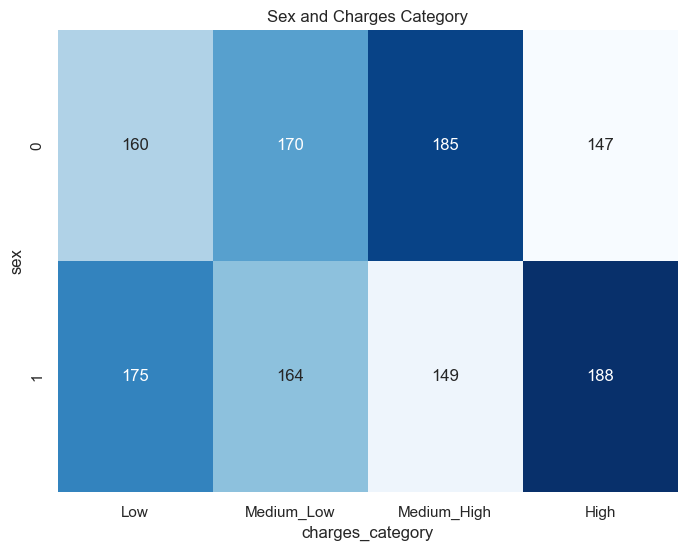

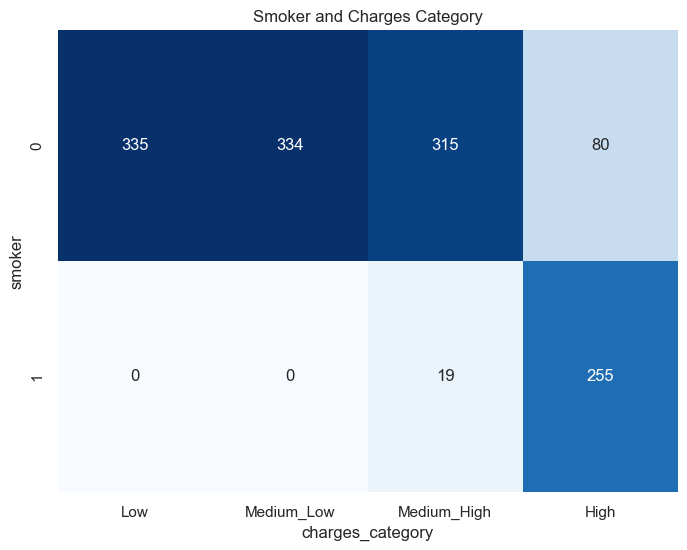

Text(0.5, 1.0, 'Region and Charges Category')

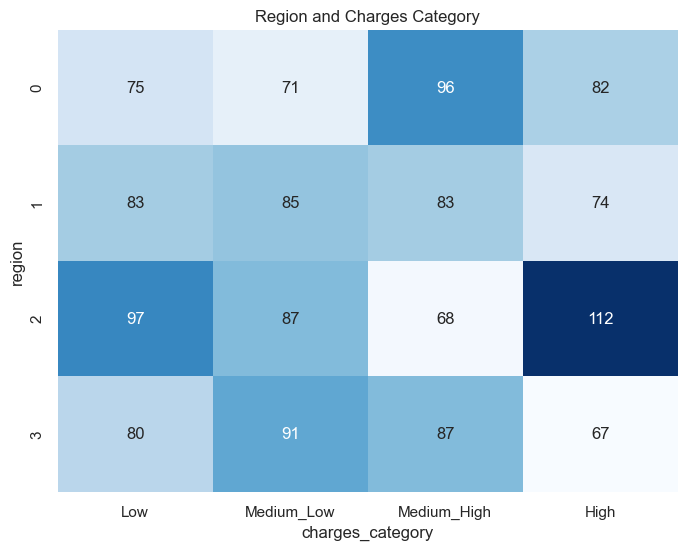

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

sex_charges_crosstab = pd.crosstab(insured['sex'] , insured['charges_category'])
smoker_charges_crosstab = pd.crosstab(insured['smoker'] , insured['charges_category'])
region_charges_crosstab = pd.crosstab(insured['region'] , insured['charges_category'])

# sex와 charges_category의 히트맵
plt.figure(figsize=(8, 6))
sns.heatmap(sex_charges_crosstab, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title('Sex and Charges Category')
plt.show()

# smoker와 charges_category의 히트맵
plt.figure(figsize=(8, 6))
sns.heatmap(smoker_charges_crosstab, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title('Smoker and Charges Category')
plt.show()

# region과 charges_category의 히트맵
plt.figure(figsize=(8, 6))
sns.heatmap(region_charges_crosstab, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title('Region and Charges Category')


이젠, 관계있는 애들끼리를 가지고 예측모델을 만들어보자.    
**로지스틱 회귀분석**으로 회귀분석 한번 해보고, **랜덤포레스트**으로 한번 더 해보기로 했다.     

## Regression Model
    
----
| 로지스틱 회귀분석: 기본적으로는 종속변수가 두 개의 클래스를 갖는 범주형일 때 분류기법으로 사용   
| https://m.blog.naver.com/winddori2002/221706766540    
    
로지스틱 회귀분석 검정은 최대우도법, 경사하강법(Gradient Descent) 이 두가지 방법이 있는데, 경사하강법으로 해보기로 결정.   
=> (수정) 이건 로지스틱 회귀가 안되는 데이터이다! 모델은 y에 해당되는 피처의 데이터타입에 따라 결정되는데, 이것은 연속형(숫자)이기 때문.   
=> 무조건 선형회귀만 되는 데이터이다!!!! (이러니까 모델 피팅을 해도 정확도가 0.5 이러지..)

### 원래 Logistic Regression 하려고 썼던 코드
    
모델 정하는게 X에 해당되는 피처들에 따라 정해진다고 생각하여 일어난 일...    
x들이 범주형 변수니까 로지스틱을 써야하며, 이를 위해 y도 범주형으로 바꿔야겠다는 참신한 발상을 했다.   
이를 위해, y를 구간별로 범주로 나누는 코드가 포함되어있다.

In [106]:
# 훈련/테스트 데이터 분리
from sklearn.model_selection import train_test_split

y = insured['charges_category']
X = insured[['sex', 'smoker', 'region', 'children']]   # insured.drop('charges', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(1070, 268, 1070, 268)

In [107]:
# 데이터 정규화 - StandardScaler 사용
from sklearn.preprocessing import StandardScaler  
  
scaler = StandardScaler()  

X_train = scaler.fit_transform(X_train)  
X_test = scaler.transform(X_test)

In [108]:
# 로지스틱 회귀 모델 훈련

from sklearn.linear_model import LogisticRegression  
  
model = LogisticRegression()  
model.fit(X_train, y_train)

LogisticRegression()

In [109]:
print(model.score(X_train, y_train))    # 훈련 데이터셋의 정확도
print(model.score(X_test, y_test))      # 테스트 데이터셋의 정확도

0.5177570093457944
0.5447761194029851


In [110]:
print(model.coef_)

[[-0.00696641  1.90191921 -0.03801916  0.17214155]
 [ 0.08617019 -1.13424733 -0.00442448 -0.5329501 ]
 [-0.06372826  0.34425241 -0.05466347  0.00223   ]
 [-0.01547553 -1.11192429  0.09710712  0.35857855]]


![alt text](image.png)

smoker만 관계가 높은 것 보고 smoker만 가지고 해보자

In [73]:
# 훈련/테스트 데이터 분리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression  

s_y = np.array(insured['charges_category'])
s_X = np.array(insured['smoker']).reshape(-1, 1)   # insured.drop('charges', axis=1)
s_X_train, s_X_test, s_y_train, s_y_test = train_test_split(s_X, s_y, test_size=0.2, random_state=42)

scaler = StandardScaler()  

s_X_train = scaler.fit_transform(s_X_train)  
s_X_test = scaler.transform(s_X_test)

# 로지스틱 회귀 모델 훈련
model = LogisticRegression()  
model.fit(s_X_train, s_y_train)

print(model.score(s_X_train, s_y_train))    # 훈련 데이터셋의 정확도
print(model.score(s_X_test, s_y_test))      # 테스트 데이터셋의 정확도

0.4373831775700935
0.45149253731343286


오히려 정확도가 떨어졌다! 변수 세개를 가지고 할 때 더 높은 정확도가 나왔다    
~~아예 모델을 처음부터 잘못 시작하니 그렇지...~~

----
### Linear Regression로 수정한 코드